Couldn't find free GPU
Linear reconstruction PSNR: 15.89 dB
PGD reconstruction PSNR: 15.93 dB


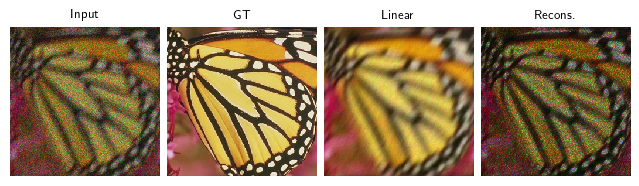

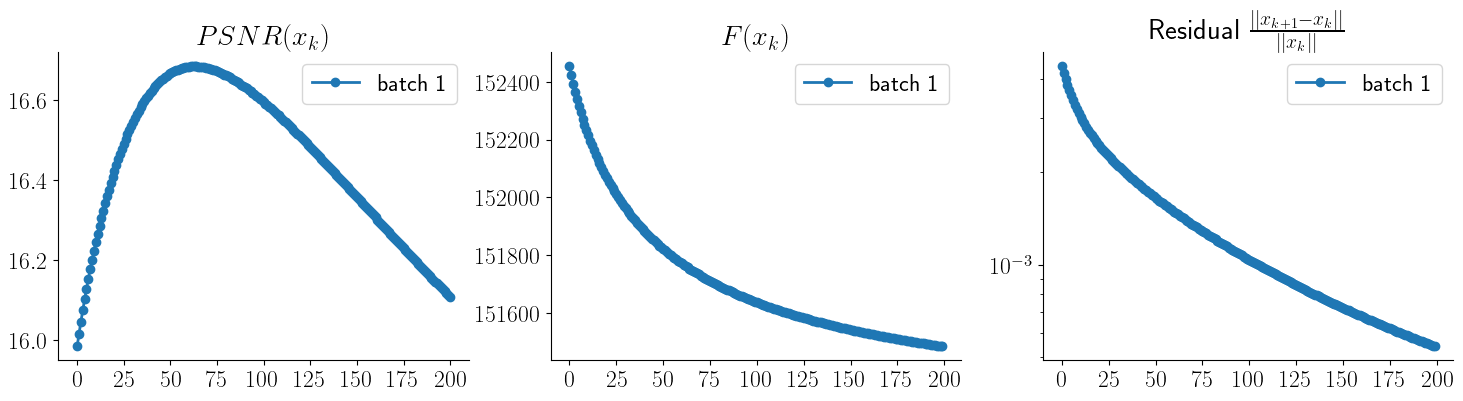

In [15]:
"""
Poisson image deblurring with Mirror Descent.
====================================================================================================

This example shows how to use mirror descent with Burg's entropy Bregman potential in order to solve Poisson Inverse Problems. 
The problem writes as :math:`y = \mathcal{P}(Ax)` where :math:`A` is a convolutional operator and :math:`\mathcal{P}` is the realization of some Poisson noise. The goal is
to recover the original image :math:`x` from the blurred and noisy image :math:`y`. The TV prior is used to regularize the problem.
"""

import deepinv as dinv
from pathlib import Path
import torch
from torchvision import transforms

from deepinv.optim.data_fidelity import PoissonLikelihood
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_dataset, load_degradation
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.optim_iterators.bregman import BurgEntropy

# %%
# Setup paths for data loading and results.
# ----------------------------------------------------------------------------------------
#

BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"
DATA_DIR = BASE_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"


# %%
# Load base image datasets and degradation operators.
# ----------------------------------------------------------------------------------------
# In this example, we use the Set3C dataset and a motion blur kernel from
# `Levin et al. (2009) <https://ieeexplore.ieee.org/abstract/document/5206815/>`_.
#

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Set up the variable to fetch dataset and operators.
dataset_name = "set3c"
img_size = 256 if torch.cuda.is_available() else 64
val_transform = transforms.Compose(
    [transforms.CenterCrop(img_size), transforms.ToTensor()]
)

# Generate a motion blur operator.
kernel_index = 1  # which kernel to chose among the 8 motion kernels from 'Levin09.mat'
kernel_torch = load_degradation("Levin09.npy", DEG_DIR / "kernels", index=kernel_index)
kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(
    0
)  # add batch and channel dimensions
dataset = load_dataset(dataset_name, ORIGINAL_DATA_DIR, transform=val_transform)


# %%
# Generate a dataset of blurred images and load it.
# --------------------------------------------------------------------------------
# We use the BlurFFT class from the physics module to generate a dataset of blurred images.


noise_level_img = 40  # Poisson Noise gain
n_channels = 3  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.BlurFFT(
    img_size=(n_channels, img_size, img_size),
    filter=kernel_torch,
    device=device,
    noise_model=dinv.physics.PoissonNoise(gain=noise_level_img),
)

# Select the first image from the dataset
x = dataset[0][0].unsqueeze(0).to(device)

# Apply the degradation to the image
y = physics(x)

# Select the data fidelity term
data_fidelity = PoissonLikelihood()

# Specify the prior
prior = dinv.optim.prior.Tikhonov()

# Logging parameters
verbose = True
plot_metrics = True  # compute performance and convergence metrics along the algorithm, curved saved in RESULTS_DIR

# Algorithm parameters. The Bregman potential used for Mirror Descent (here Brug's entropy) is defined in the params_algo dictionary.
stepsize = 0.1
lamb = 0.1  # TV regularisation parameter
params_algo = {"stepsize": stepsize, "lambda": lamb, "bregman_potential": BurgEntropy()}
max_iter = 200
early_stop = True
backtracking = True

# Instantiate the algorithm class to solve the problem.
model = optim_builder(
    iteration="MD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    backtracking=backtracking,
)

# %%
# Evaluate the model on the problem and plot the results.
# --------------------------------------------------------------------
#
# The model returns the output and the metrics computed along the iterations.
# For computing PSNR, the ground truth image ``x_gt`` must be provided.


x_lin = physics.A_adjoint(y)  # linear reconstruction with the adjoint operator

# run the model on the problem.
x_model, metrics = model(
    y, physics, x_gt=x, compute_metrics=True
)  # reconstruction with PGD algorithm

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"PGD reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_model):.2f} dB")

# plot images. Images are saved in RESULTS_DIR.
imgs = [y, x, x_lin, x_model]
plot(
    imgs,
    titles=["Input", "GT", "Linear", "Recons."],
)

# plot convergence curves. Metrics are saved in RESULTS_DIR.
if plot_metrics:
    plot_curves(metrics)
